## Getting the code
Download the repository and `cd` to the directory

In [1]:
!git clone https://github.com/abcsds/NPLab

fatal: destination path 'NPLab' already exists and is not an empty directory.


## Required libaries
Different libraries will be used. These are not installed by default on a python distribution. They must be installed with pip:

In [2]:
!pip install numpy matplotlib scipy pyxdf biosppy pandas

In [3]:
import pyxdf  # Open xdf files
import matplotlib.pyplot as plt  # used for plotting
import numpy as np  # Numeric library for python

## Open the singnals data
The data recorded during the lab is in the xdf format. It is oppened with the pyxdf library, getting the data, and a header with metadata from the experiment. The data object contains one object for every stream recorded during the lab. In this case, threre are three streams: the biosignals, the markers for the biosignals (not used here) and the markers from psychopy.

We visualize the signals and markers here:

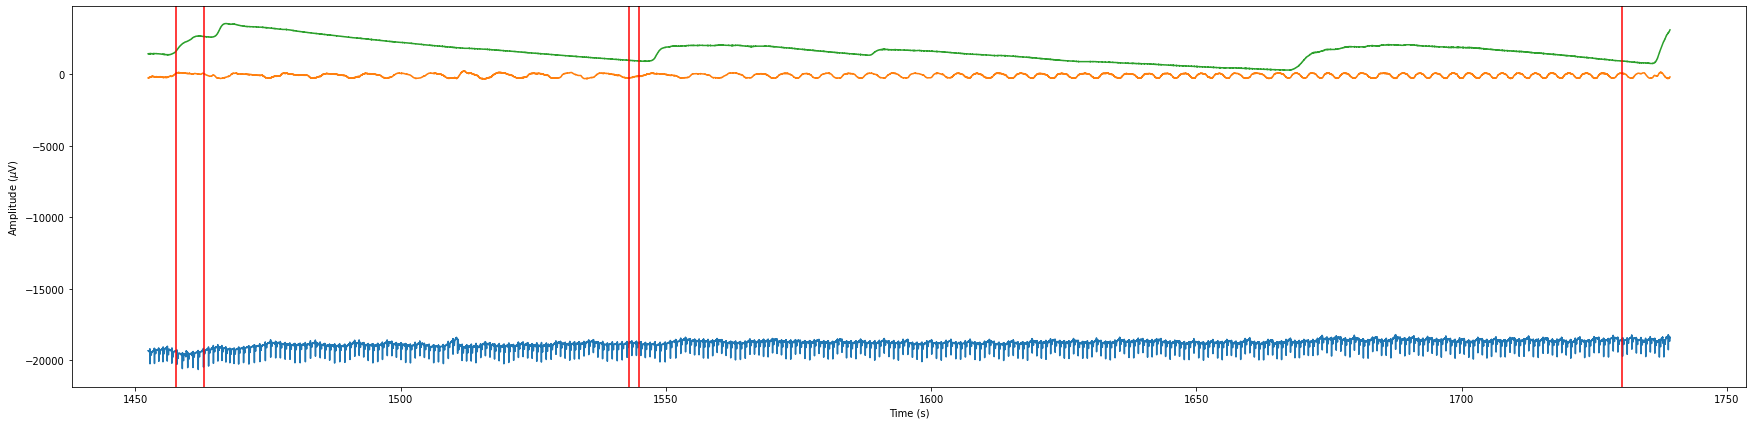

In [4]:
data, header = pyxdf.load_xdf('NPLab/analysis/raw/000.xdf')

plt.figure(figsize=(30, 7))

# Read the biosignals from the first stream
stream = data[0]
y = stream['time_series']
fs = int(stream["info"]["nominal_srate"][0])  # Store sample frequency (fs)
plt.plot(stream["time_stamps"], y)
ecg, resp, gsr = np.split(y, [1, 2], axis=1)  # Store three biosignals
t = stream["time_stamps"]  # Extract time array

# Read the markers from the third stream
stream = data[2]
markers = {}  # A variable to store the markers
for marker, ts in zip(stream["time_series"], stream["time_stamps"]):
    plt.axvline(x=ts, c="red")
    markers[marker[0]] = ts
plt.xlabel("Time (s)")
plt.ylabel("Amplitude ($\mu$V)")
plt.show()

## Signal processing
Signal filtering is done with help of the scipy library.

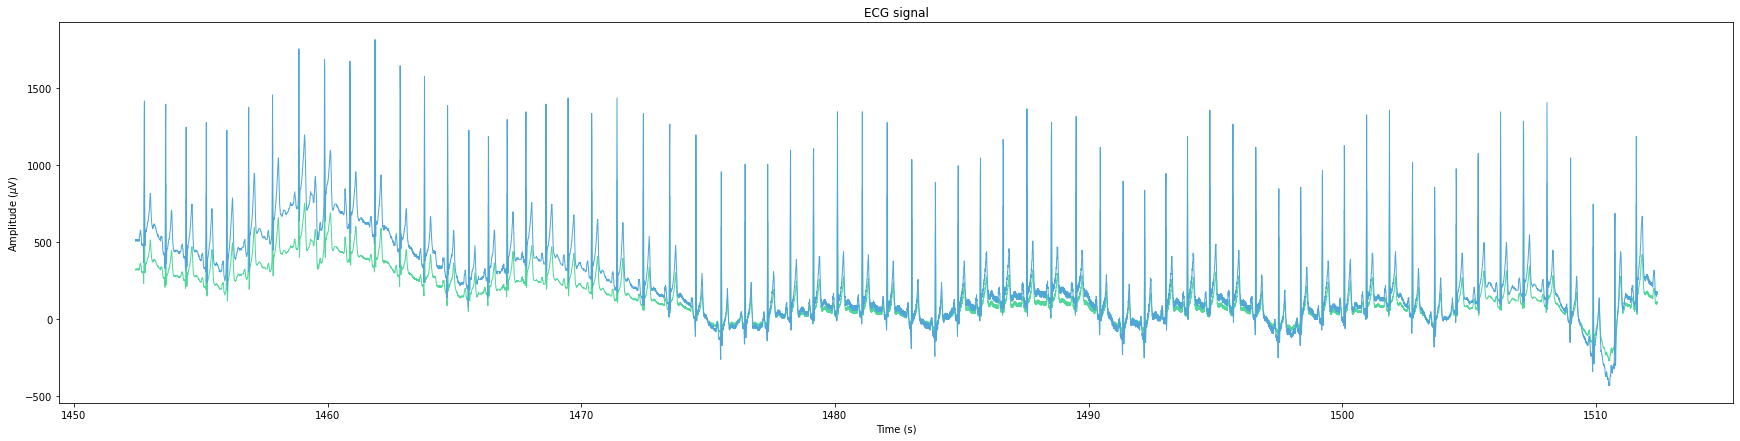

In [5]:
from scipy import signal


def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.lfilter(b, a, data)
    return y


def notch_filter(data, fs, f0=50, Q=30):
    b, a = signal.iirnotch(f0, Q, fs)
    y = signal.lfilter(b, a, data)
    return y


def detrend_filter(data):
    return data - data.mean()


non_filtered = detrend_filter(-ecg)
filtered_sig = bandpass_filter(non_filtered, 0.01, 45, fs)
filtered_sig = notch_filter(filtered_sig, fs)

samples = 6000
plt.figure(figsize=(30, 7))  # Size in inches
plt.title("ECG signal")
plt.plot(t[0:samples], filtered_sig[0:samples], color="#51d79b", linewidth=1)
plt.plot(t[0:samples], non_filtered[0:samples], color="#51A6D8", linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude ($\mu$V)")
plt.show()

## Analysis of ECG
For ECG analysis the biosppy library is used. This is mostly due to the specialized peak detection algorithm.

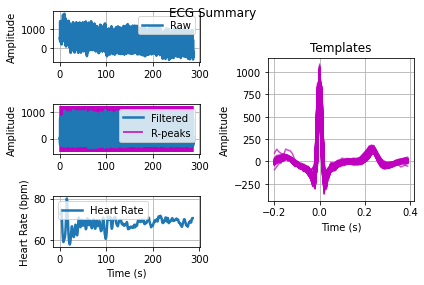

In [6]:
from biosppy.signals import ecg

# load raw ECG signal
sig = non_filtered.flatten()

# process it and plot
out = ecg.ecg(signal=sig, sampling_rate=fs, show=True)

The signal is processed automatically. The results are visualized here:

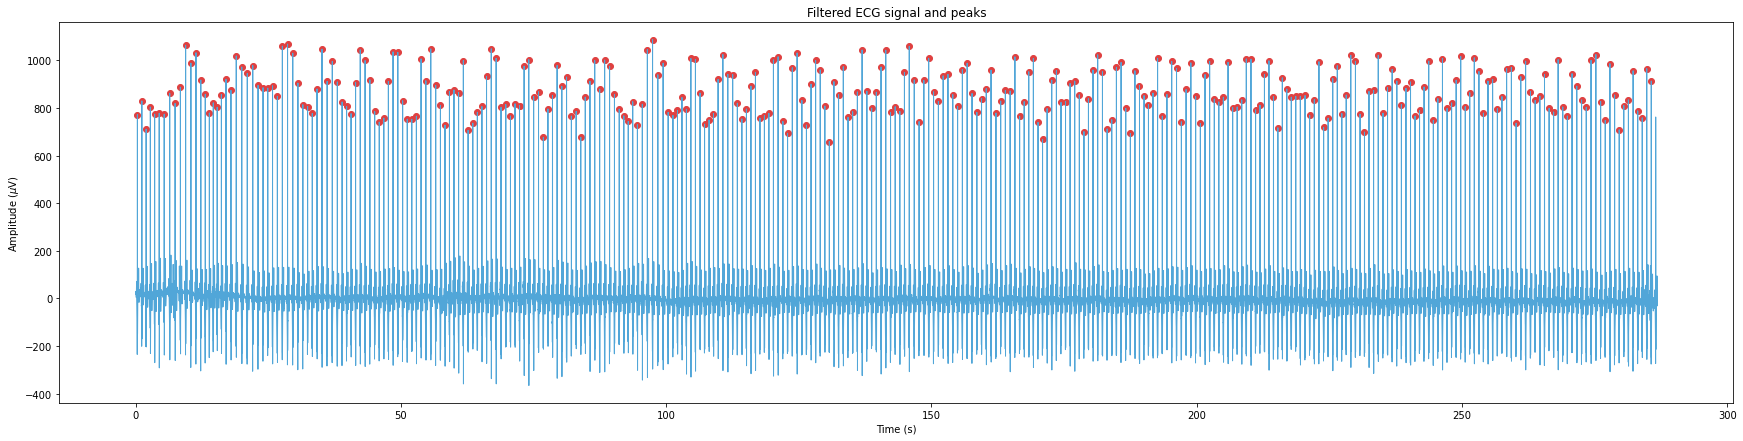

In [7]:
plt.figure(figsize=(30, 7))
plt.title("Filtered ECG signal and peaks")
plt.plot(out["ts"], out["filtered"],
         color="#51A6D8",
         linewidth=1)
plt.scatter(out["ts"][out["rpeaks"]],
            out["filtered"][out["rpeaks"]],
            color="#df4040",
            linewidth=1)
# plt.xlim(0, 290)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude ($\mu$V)")
plt.show()

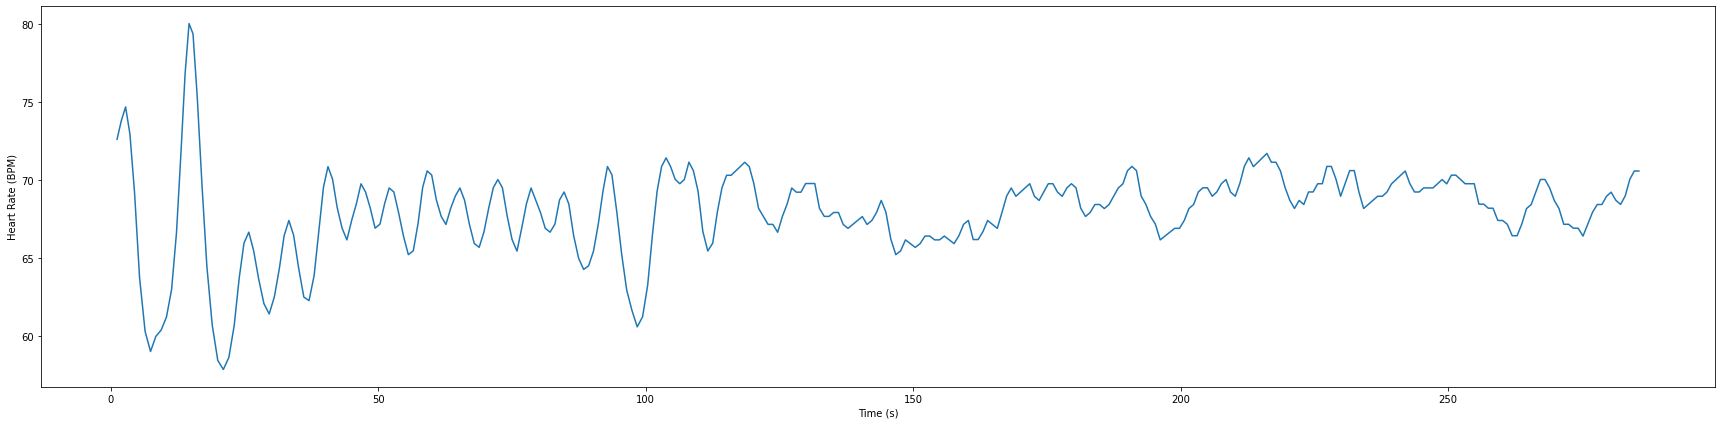

In [8]:
plt.figure(figsize=(30, 7))
plt.plot(out["heart_rate_ts"], out["heart_rate"])
plt.xlabel("Time (s)")
plt.ylabel("Heart Rate (BPM)")
plt.show()

## Heart Rate variability
The SDNN method is used to evaluate heart rate variability. For this, the rr-intervals (also called nn-intervals) are necesary. These are the discrete derivative of the `rpeaks' signal. That is to say, the difference in time between one peak and the previous.

Reference:

Shaffer, F., & Ginsberg, J. P. (2017). An Overview of Heart Rate Variability Metrics and Norms. Frontiers in Public Health, 5, 258. https://doi.org/10.3389/fpubh.2017.00258


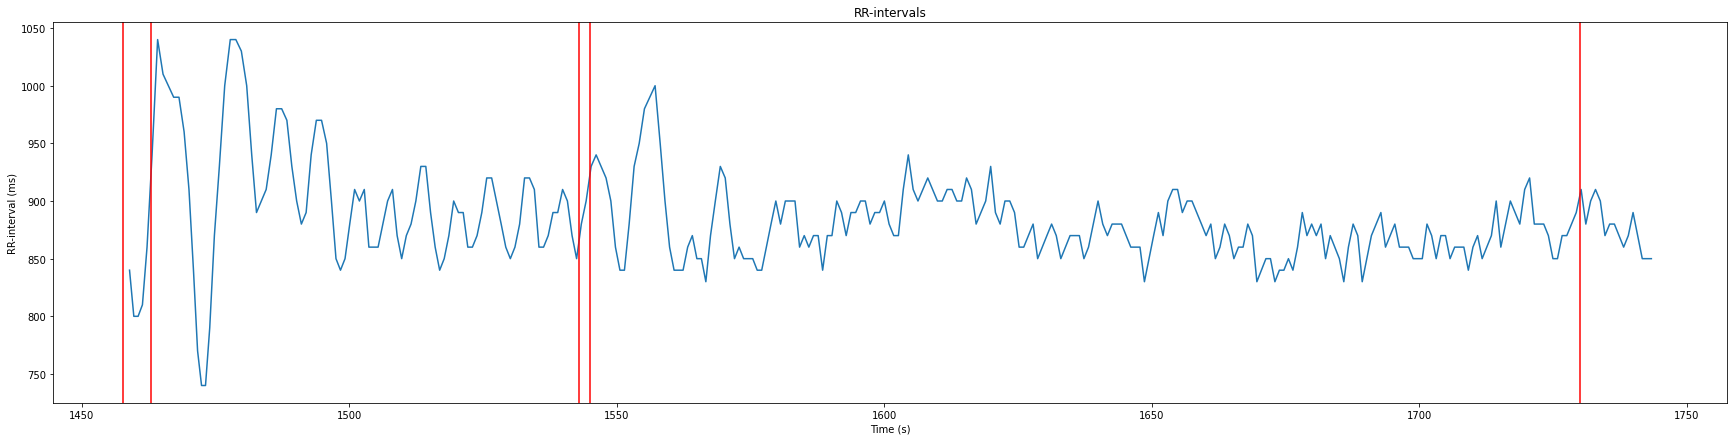

In [9]:
rr_intervals = np.diff(out["ts"][out["rpeaks"]], prepend=[np.nan])
rr_intervals *= 1000  # Convert from s to ms
stream = data[2]
plt.figure(figsize=(30, 7))
plt.title("RR-intervals")
plt.plot(out["ts"][out["rpeaks"]] + stream["time_stamps"].min(),
         rr_intervals)
for n in markers:
    plt.axvline(x=markers[n], c="red")
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

 The last step towards obtaining the SDNN values for HRV is to apply a rollinng window standard deviation. Here, the size of the window is 8 seconds.


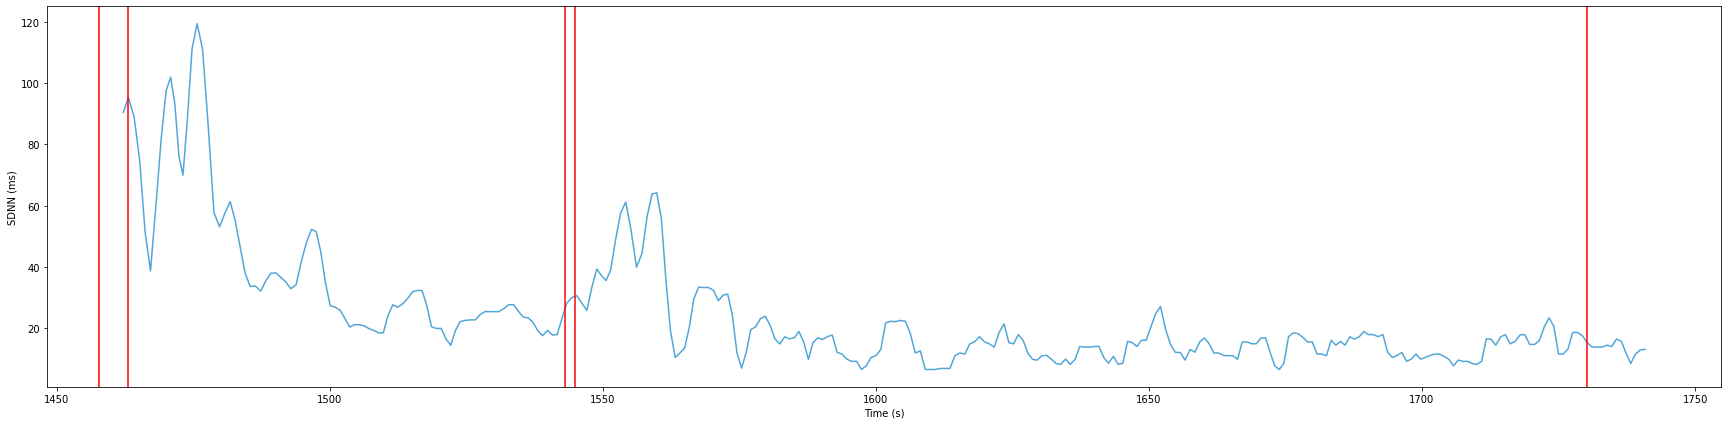

In [10]:
# Rolling window for SDNN
def rolling_std(vec, window_size):
    shape = vec.shape[:-1] + (vec.shape[-1] - window_size + 1, window_size)
    strides = vec.strides + (vec.strides[-1],)
    windows = np.lib.stride_tricks.as_strided(vec,
                                              shape=shape,
                                              strides=strides)
    rstd = np.hstack((np.zeros(window_size // 2) + np.nan,
                      np.std(windows, 1),
                      np.zeros((window_size // 2) - 1) + np.nan))
    return rstd


n = 8 # Must be even number for now
hrv = rolling_std(rr_intervals, n)
plt.figure(figsize=(30, 7))
plt.plot(out["ts"][out["rpeaks"]] + stream["time_stamps"].min(),
         hrv,
         color="#51A6D8")
for marker, ts in zip(stream["time_series"], stream["time_stamps"]):
    plt.axvline(x=ts, c="red")
plt.xlabel("Time (s)")
plt.ylabel("SDNN (ms)")
plt.show()

## Breath Frequency

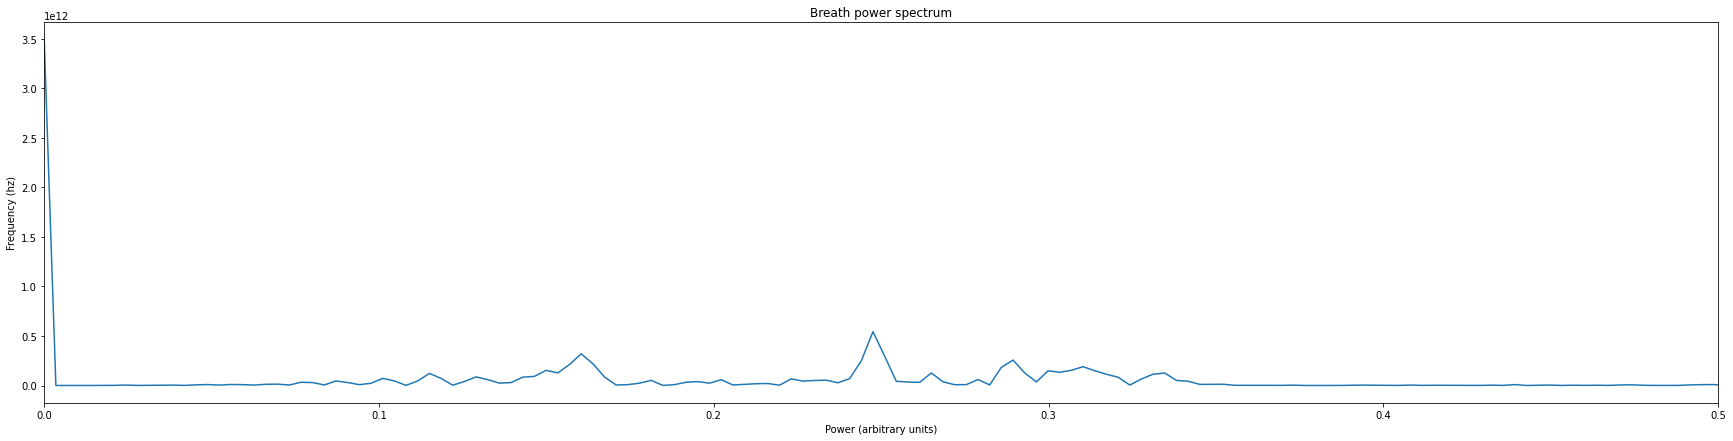

In [11]:
sig = resp.flatten()

# Filters, in case of noisy signal
# sig = bandpass_filter(sig, 0.05, .4, fs)  # 3-24 breaths per minute

ps = np.abs(np.fft.fft(sig))**2 # Power spectrum

freqs = np.fft.fftfreq(sig.size, 1/fs)
idx = np.argsort(freqs)

plt.figure(figsize=(30, 7))
plt.title("Breath power spectrum")
plt.plot(freqs[idx], ps[idx])
plt.xlim(0,.5)
plt.xlabel("Power (arbitrary units)")
plt.ylabel("Frequency (hz)")
plt.show()

Obtaining the greatest peak in the spectrum yields the breath frequency.

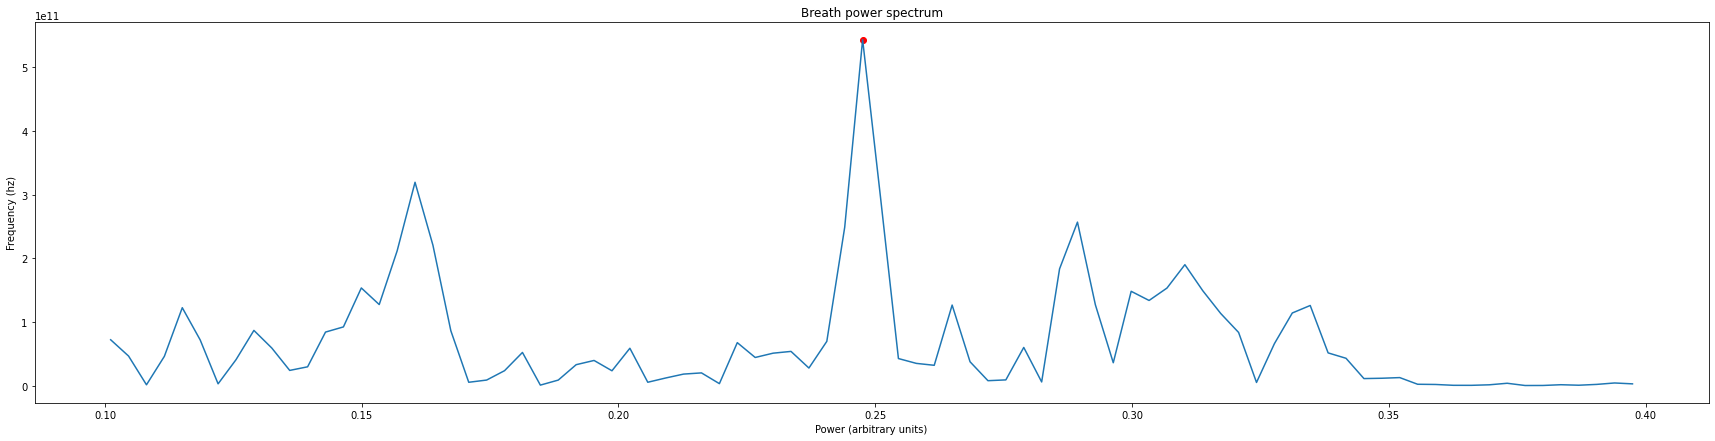

In [12]:
b_idx = np.where((0.1 < freqs[idx]) & (freqs[idx] < 0.4))
b_freqs = freqs[idx][b_idx]
b_ps = ps[idx][b_idx]

imax = np.argmax(b_ps)
f_max = b_freqs[imax]
ps_max = b_ps[imax]

plt.figure(figsize=(30, 7))
plt.title("Breath power spectrum")
plt.plot(b_freqs, b_ps)
plt.scatter([f_max], [ps_max], color="red")
plt.xlabel("Power (arbitrary units)")
plt.ylabel("Frequency (hz)")
plt.show()

Lastly, we build the breath frequency detector into a function to be used in a further analysis.

In [13]:
def breath_frequency(sig, fs, filter=False):
    """ Returns the peak frequency in bpm of a spectrum within the bounds 
        of respiration frequencies
    """
    if filter:
        sig = bandpass_filter(sig, 0.05, .4, fs)  # 3-24 breaths per minute
    ps = np.abs(np.fft.fft(sig))**2
    freqs = np.fft.fftfreq(sig.size, 1/fs)
    idx = np.argsort(freqs)
    b_idx = np.where((0.1 < freqs[idx]) & (freqs[idx] < 0.4))
    b_freqs = freqs[idx][b_idx]
    b_ps = ps[idx][b_idx]
    imax = np.argmax(b_ps)
    return b_freqs[imax] * 60  # convert to BPM


In [14]:
breath_frequency(sig, fs)

14.852520744717943

## Segmentation
To test the different conditions within the same experiment (baseline and the condition) the signals must be segmented by the markers. 

With this experimental design, the relevant segments are between markers (2,3) for baseline, and (4,5) for the stressor condition.

There is also two different frequencies, the processed signals are in a 1hz frequency (one sample per second) and the raw signals are in a 100hz frequency (the sample rate of the amplifier). They are thus, processed separately.

In [15]:
# Segment variables in seconds
# out["heart_rate"] contains the heart rate signal
# rr_intervals contains the rr-interval (hrv is the standard deviation of this along the segment)
time = out["ts"][out["rpeaks"]] + stream["time_stamps"].min()
time.shape
baseline_time = np.where((markers[2] < time) & (time < markers[3]))
baseline_hr = out["heart_rate"][baseline_time]
baseline_rr = rr_intervals[baseline_time]

condition_time = np.where((markers[4] < time) & (time < markers[5]))
condition_hr = out["heart_rate"][condition_time]
condition_rr = rr_intervals[condition_time]

# Segment variables in samples
resp.shape
gsr.shape
t.shape
baseline_t = np.where((markers[2] < t) & (t < markers[3]))
baseline_gsr = gsr[baseline_t]
baseline_resp = resp[baseline_t]

condition_t = np.where((markers[4] < t) & (t < markers[5]))
condition_gsr = gsr[condition_t]
condition_resp = resp[condition_t]

## Setting data in a table
The Pandas library is used to setup the results as a DataFrame (a tabular format).

In [16]:
# Build results table
import pandas as pd


res = {"Variable": ["HR (BPM)",
                    "HRV (SDNN)",
                    "Resp (arb)",
                    "GSR (arb)"],
       "Baseline": [baseline_hr.mean(),
                    baseline_rr.std(),
                    breath_frequency(baseline_resp, fs),
                    baseline_gsr.mean()],
       "Condition": [condition_hr.mean(),
                     condition_rr.std(),
                     breath_frequency(condition_resp, fs),
                     condition_gsr.mean()]}
results = pd.DataFrame(res)
results.to_csv("NPLab/analysis/results.csv", index=False, float_format="%.4f")

## Result Analysis
We can see in the table created, that the stressing condition has a higher average heart rate, a lower HRV, a slower respiration, and an lower average skin conductance.

In [17]:
results

,Variable,Baseline,Condition
0,HR (BPM),66.853981,68.482770
1,HRV (SDNN),59.106539,28.224063
2,Resp (arb),6.750000,6.481932
3,GSR (arb),2196.626221,1390.752441
